In [1]:
from IPython import display

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import os
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow import keras
import time

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os

os.makedirs('utils/', exist_ok=True)
os.chdir('utils')

! wget https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/models.py
! wget https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/losses.py
! wget https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/vision.py
! wget https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/callbacks.py
! wget https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/utils.py

os.chdir('/content')
print("Current working directory", os.getcwd())

--2023-11-24 14:21:52--  https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/models.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21013 (21K) [text/plain]
Saving to: ‘models.py’

models.py           100%[===================>]  20.52K  --.-KB/s    in 0.003s  

2023-11-24 14:21:52 (7.25 MB/s) - ‘models.py’ saved [21013/21013]

--2023-11-24 14:21:53--  https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/losses.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8545 (8.3K) [text/plain]
Savi

In [4]:
from utils import vision
from utils import utils
from utils import losses

### Experiment Parameters

In [43]:
experiment = {
    'TYPE': 'train',        # Experiment type: 'train', 'test'
    'ACCELERATOR': 'GPU',   # 'GPU' or 'TPU'

    'IMAGE_SIZE': (256, 256),
    'INPUT_SHAPE': (256, 256, 3),
    'IMAGE_PARTITION': True,
    'PATCH_SIZE': 256,      # default 224. (224, 224) VGG Input
    'VALID_SIZE': 0.0,      # Validation data size: (Valid Data) / (All Data)
    'DATA_AUG': True,       # Apply data augmentation

    'BACKBONE': 'custom',        # 'custom', 'VGG16', 'VGG19' - default 'custom'
    'LAST_TRANIABLE_LAYERS': 5,  # number of last trainable layers of pre-trained backbone models, fine-tuning
    'BATCH_SIZE': 16,            # IF TPU is active set 4, otherwise set anything
    'EPOCHS': 250,
    'OPTIMIZER': 'Adam',  # TODO: Try 'rmsprop' optimizer
    'LEARNING_RATE': 1e-4,

    'RECONS_LOSS': 'PERCEPTUAL',  # Reconstruction loss ('SSIM', 'MSE', 'MAE', 'PERCEPTUAL')
    'PERCEPTUAL_LAYERS': [5,8,13,18],    # [5,8,13,18], None
    'PERCEP_LOSS_MODEL': 'VGG19', # custom', 'VGG16', 'VGG19' - default 'VGG16'
    'PERP_LOSS_LAMBDA': 1,
    'LRELU_SLOPE': 0.2,       # Leaky ReLU activation function slope value
    'MSE_LOSS_LAMBDA': 0.01,  # MSE coeff

    # set the dimensionality of the latent space to a plane for visualization later
    'LATENT_DIM': 500,

    'SAVE_WEIGHTS_PER_EPOCH': 10,
    # Record directory of model's trained weights
    'TRAINING_WEIGHT_DIR': "tf_vae/BD67_dataset/training_weights",
    # Record directory of generated images
    'IMGS_DIR': "tf_vae/BD67_dataset/images",
}

### Determining Reconstructing Loss Function

* **MSE** (Mean Squared Error): Pixel-Wise Reconstruction Loss, L2 rergularization (Ridge)
MSE = Σ (pixel_original - pixel_reconstructed)^2 / N

* **MAE** (Mean Absolute Error): Pixel-Wise Reconstruction Loss, L1 rergularization (Lasso)
MAE = Σ (pixel_original - pixel_reconstructed) / N

* **Feature-Wise Reconstruction Loss**: A common approach is to use a `perceptual loss` or `content loss`, which compares the high-level features or activations of intermediate layers of a pre-trained neural network
1. Encode the input image into a latent vector using the pre-trained model (encoder). Ex. `VGG19 model`

2. Reconstruct an image from latent vector using the decoder.

3. Calculate the loss based on the similarity between the input image and the reconstructed image.

In [6]:
if experiment['ACCELERATOR'] == 'TPU':
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
    tf.config.experimental_connect_to_cluster(resolver)

    # This is the TPU initialization code that has to be at the beginning.
    tf.tpu.experimental.initialize_tpu_system(resolver)
    strategy = tf.distribute.TPUStrategy(resolver)
    # Increase batch_size to improve the efficiency provided by TPU usage
    experiment['BATCH_SIZE'] = experiment['BATCH_SIZE'] * strategy.num_replicas_in_sync
    print("All devices:  ", tf.config.list_logical_devices('TPU'))
    print("All replicas: ", strategy.num_replicas_in_sync)
else:
    strategy = tf.distribute.get_strategy()

In [7]:
# Process batches as much as per_replica_batch_size per TPU
per_replica_batch_size = experiment['BATCH_SIZE'] // strategy.num_replicas_in_sync

In [8]:
experiment['BATCH_SIZE']

16

In [9]:
print("Number of cores(replicas) in sync: ", strategy.num_replicas_in_sync)
print("Batch size: ", experiment['BATCH_SIZE'])
print("Batch size per replica: ", per_replica_batch_size)

Number of cores(replicas) in sync:  1
Batch size:  16
Batch size per replica:  16


In [10]:
ROOT_PATH = '/content'
DATASET_PATH = '/content/drive/MyDrive/MASTER/Master_Thesis/Dataset/BD67_Dataset'

BD67_NORMAL_FRONT_PATH = os.path.join(DATASET_PATH, 'defect_free/Front/cropped')
BD67_NORMAL_FRONT_ROTATED_PATH = os.path.join(DATASET_PATH, 'defect_free/Front/rotated_images/cropped')
BD67_NORMAL_REAR_PATH = os.path.join(DATASET_PATH, 'defect_free/Rear')
BD67_DEFECTED_FRONT_PATH = os.path.join(DATASET_PATH, 'defected/Front/cropped')
BD67_DEFECTED_REAR_PATH = os.path.join(DATASET_PATH, 'defected/Rear')
if experiment['IMAGE_PARTITION'] == True:
  BD67_NORMAL_FRONT_PATH_PART_0 = os.path.join(DATASET_PATH, 'defect_free/Front/partitioned/grid_0')
  BD67_NORMAL_FRONT_PATH_PART_1 = os.path.join(DATASET_PATH, 'defect_free/Front/partitioned/grid_1')
  BD67_NORMAL_FRONT_PATH_PART_2 = os.path.join(DATASET_PATH, 'defect_free/Front/partitioned/grid_2')
  BD67_NORMAL_FRONT_PATH_PART_3 = os.path.join(DATASET_PATH, 'defect_free/Front/partitioned/grid_3')
  BD67_NORMAL_FRONT_PATH_PART_4 = os.path.join(DATASET_PATH, 'defect_free/Front/partitioned/grid_4')
  BD67_NORMAL_FRONT_PATH_PART_5 = os.path.join(DATASET_PATH, 'defect_free/Front/partitioned/grid_5')
  BD67_DEFECTED_FRONT_PATH_PART_0 = os.path.join(DATASET_PATH, 'defected/Front/partitioned/grid_0')
  BD67_DEFECTED_FRONT_PATH_PART_1 = os.path.join(DATASET_PATH, 'defected/Front/partitioned/grid_1')
  BD67_DEFECTED_FRONT_PATH_PART_2 = os.path.join(DATASET_PATH, 'defected/Front/partitioned/grid_2')
  BD67_DEFECTED_FRONT_PATH_PART_3 = os.path.join(DATASET_PATH, 'defected/Front/partitioned/grid_3')
  BD67_DEFECTED_FRONT_PATH_PART_4 = os.path.join(DATASET_PATH, 'defected/Front/partitioned/grid_4')
  BD67_DEFECTED_FRONT_PATH_PART_5 = os.path.join(DATASET_PATH, 'defected/Front/partitioned/grid_5')

### Read TFRecord File

In [11]:
TFRECORD_TRAIN_PATH_LOCAL = '/content/images.tfrecords'
TFRECORD_TEST_PATH_LOCAL = '/content/images_test.tfrecords'

In [12]:
import shutil

if experiment['ACCELERATOR'] == 'TPU':
    # Use the shutil.copy() method to copy the TFRecord file in Google drive to the local workspace
    shutil.copy(TFRECORD_TRAIN_PATH_LOCAL, ROOT_PATH)
    shutil.copy(TFRECORD_TEST_PATH_LOCAL, ROOT_PATH)

In [13]:
# Create a dictionary describing the features.
image_feature_description = {
    'height': tf.io.FixedLenFeature([], tf.int64),
    'width': tf.io.FixedLenFeature([], tf.int64),
    'depth': tf.io.FixedLenFeature([], tf.int64),
    'label': tf.io.FixedLenFeature([], tf.int64),
    'image_raw': tf.io.FixedLenFeature([], tf.string),
}

In [14]:
# Returns "File system scheme '[local]' not implemented (file: '/bufferedio/content/images.tfrecords')" Error
# The dataset should be stored in GCS (Google Cloud Storage)
# image_dataset = read_tfRecord_image('/content/images.tfrecords', image_feature_description)

### Prepare Data

In [15]:
img_files = utils.get_image_file_list(BD67_NORMAL_FRONT_PATH, 'png')
rotated_img_files = utils.get_image_file_list(BD67_NORMAL_FRONT_ROTATED_PATH, 'png')
all_img_files = img_files + rotated_img_files

print("Number of flat image files: ", len(img_files))
print("Number of rotated image files: ", len(rotated_img_files))
print("Number of all image files: ", len(all_img_files))

Number of flat image files:  110
Number of rotated image files:  105
Number of all image files:  215


In [16]:
img_files = utils.get_image_file_list(BD67_NORMAL_FRONT_PATH_PART_0, 'png')

### Data Augmentation Layer

In [17]:
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Setup data augmentation
data_augmentation = Sequential([
  #preprocessing.RandomFlip("horizontal_and_vertical"), # randomly flip images on horizontal/vertical edge
  #preprocessing.RandomRotation(0.2), # randomly rotate images by a specific amount
  #preprocessing.RandomZoom(0.2), # randomly zoom into an image
  tf.keras.layers.RandomBrightness(factor=0.2, value_range=[0.0, 1.0], seed=None),
  # value_range parameter should be [0.0, 1.0] for RandomBrightness
  # if images were scaled before, default value is [0,255]
  tf.keras.layers.RandomContrast(0.2, seed=None),
  #tf.keras.layers.RandomCrop(256, 256, seed=None), Error - Image size changes
  #preprocessing.RandomWidth(0.2), # randomly adjust the width of an image by a specific amount
  #preprocessing.RandomHeight(0.2), # randomly adjust the height of an image by a specific amount
  #preprocessing.Rescaling(1./255) # keep for models like ResNet50V2, remove for EfficientNet
], name="data_augmentation")

In [18]:
def apply_augmentation(image):
    image = data_augmentation(image, training=True)  # Apply data augmentation layers
    return image

In [19]:
train_dataset = utils.create_dataset_pipeline(img_files, batch_size=experiment['BATCH_SIZE'], img_size=experiment['IMAGE_SIZE'],
                                              scl=True, shuffle=False, num_channels=3, rot=utils.ROT_0,
                                              #aug_layer=data_augmentation, data_aug_power=2,
                                              accelerator='GPU')

In [20]:
train_dataset

<_PrefetchDataset element_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)>

In [21]:
print("Number of batches to be trained: ", len(train_dataset))

Number of batches to be trained:  7


* The `cache()` method is used to cache elements of a dataset in memory or on disk. Caching allows you to `store a portion` or the entire `dataset` in a format that can be quickly accessed during training `without repeatedly reading the data from its source` (e.g., files on disk). It helps reduce data loading time during training. When you call dataset.cache(), it caches the dataset's elements in memory by default. If you want to cache to disk, you can provide a filename as an argument to the cache() method. Caching can significantly speed up training if data loading is a bottleneck in your pipeline.

* The `prefetch()` method is used to `overlap data loading` and model training, which can lead to improved training performance. When you prefetch data, the dataset pipeline `fetches` the `next batch` of data asynchronously `while the current batch is being processed` by the model. This can help hide data loading latency and ensure that the GPU or CPU is fully utilized during training.

* `tf.data.experimental.AUTOTUNE` is used as an argument to the prefetch() method. This value allows TensorFlow to `dynamically adjust` the number of elements prefetched based on the `available system resources` and workload. It tries to optimize the prefetching for the best performance automatically.

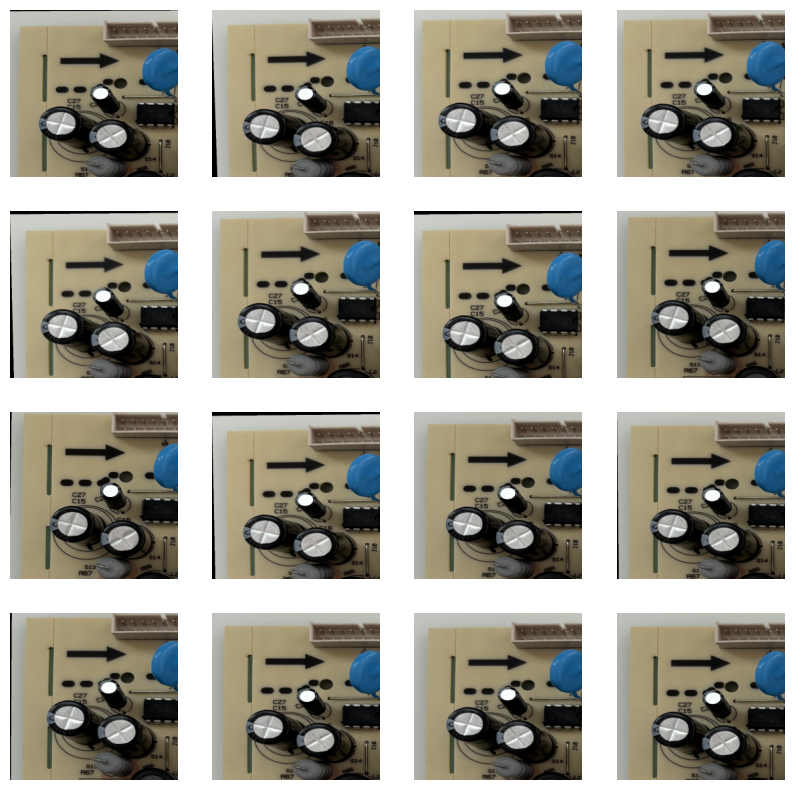

In [22]:
vision.show_image_samples_from_batch(train_dataset, grid=(4,4))

In [23]:
from tensorflow.keras.layers import Dense, Conv2D, Dropout, BatchNormalization, Input, Reshape, Flatten, Conv2DTranspose, MaxPooling2D, UpSampling2D, Add
from tensorflow.keras.layers import LeakyReLU, Lambda, ReLU, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras import layers

In [24]:
from sklearn.model_selection import train_test_split
import math

# Get number of training batches according to VALID_SIZE
training_batch_num = len(train_dataset) - math.ceil(len(train_dataset) * experiment['VALID_SIZE'])

# Prepare new training and validation batches
train_dataset_part = train_dataset.take(training_batch_num)
valid_dataset_part = train_dataset.skip(training_batch_num)

# training_files, valid_files, _, _ = train_test_split(training_files, training_files, test_size=experiment['VALID_SIZE'], random_state=100)

#print(f"Number of Training Images: {len(training_files)}")
#print(f"Number of Validation Images: {len(valid_files)}")

print("Number of training batches:   ", len(train_dataset_part))
print("Number of validation batches: ", len(valid_dataset_part))

Number of training batches:    7
Number of validation batches:  0


In [25]:
if experiment['ACCELERATOR'] == 'TPU':
  train_dataset_replica = strategy.distribute_datasets_from_function(
          lambda _: utils.get_replica_dataset(train_dataset, per_replica_batch_size, is_training=True))

In [26]:
# steps_per_epoch = len(training_files) // experiment['BATCH_SIZE']
steps_per_epoch = len(train_dataset_part)
print("Steps per epoch: ", steps_per_epoch)

Steps per epoch:  7


### Deep Convolutional Generative Adversarial Network (DCGAN)

![](https://sthalles.github.io/assets/dcgan/GANs.png)

Reference Paper: [Deep Convolutional Generative Adversarial Network (DCGAN) ](https://arxiv.org/abs/1511.06434)

Blog: [A Short Introduction to Generative Adversarial Networks
](https://sthalles.github.io/intro-to-gans/)






In the DCGAN paper, the authors describe the combination of some deep learning techniques as key for training GANs. These techniques include: the all convolutional net and (ii) Batch Normalization (BN).

The first emphasizes strided convolutions (instead of pooling layers) for both: increasing and decreasing feature’s spatial dimensions. And the second normalizes the feature vectors to have zero mean and unit variance in all layers. This helps to stabilize learning and to deal with poor weight initialization problems.

![](https://sthalles.github.io/assets/dcgan/generator-model.png)

### Generative Adversarial Network Inputs

In [27]:
random_kernel_initializer = tf.random_normal_initializer(mean=0.0, stddev=0.02)

In [28]:
def get_model_inputs(real_dim, z_dim):
  inputs_real = layers.Input(shape=(*real_dim,), name="Real_Inputs", dtype=tf.float32)
  inputs_z = layers.Input(shape=(z_dim,), name="Generated_Inputs", dtype=tf.float32)

  return inputs_real, inputs_z

### Generator

The network has `4 convolutional layers`. All followed by batch normalization `BN` (except for the output layer) and Rectified Linear unit (`ReLU`) activations. It takes as input a `random vector z` (drawn from a normal distribution). After reshaping z to have a 4D shape, we feed it to the generator that starts a series of upsampling layers.

Each upsampling layer represents a `transpose convolution` operation with `strides 2`. Basically, every time we move the convolutional kernel by one pixel on the input feature map, we move it by 2 or more pixels on the output map.

After each transpose convolution, z becomes wider and shallower. All transpose convolutions use a `5x5 kernel’s` size with depths reducing from `512` all the way down to `3` - representing an RGB color image.

The final layer outputs a `32x32x3` tensor squashed between values of `-1` and `1` through the Hyperbolic Tangent (`tanh`) function. Finally, we scale the input data to the interval of -1 to 1 to follow the choice of using the tanh function.

In [29]:
def get_generator_model(input_shape, output_dim=3, lrelu_alpha=0.2):
    """
    Generator network
    * input_shape: input random vector z (Noise)
    * output_dim: output dimension of the network (default 3 (RGB), 1 for gray scale)
    * lrelu_alpha: slope of lrelu activation function
    """
    input = layers.Input(shape=(input_shape.shape[1],), name='Generator_Input')  # TensorShape([None, 100]) => z.shape[1] = 100
    x = layers.Dense(units=4*4*512, activation=None, kernel_initializer=random_kernel_initializer, name='dense_1')(input)
    x = layers.Reshape((4, 4, 512), name='Reshape_Layer_2')(x)
    x = layers.BatchNormalization(epsilon=1e-5, momentum=0.9, name='batch_norm_1')(x)
    x = layers.LeakyReLU(lrelu_alpha)(x)

    x = layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', activation=None, kernel_initializer=random_kernel_initializer)(x)
    x = layers.BatchNormalization(epsilon=1e-5, momentum=0.9, name='batch_norm_2')(x)
    x = layers.LeakyReLU(lrelu_alpha)(x)

    x = layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', activation=None, kernel_initializer=random_kernel_initializer)(x)
    x = layers.BatchNormalization(epsilon=1e-5, momentum=0.9, name='batch_norm_3')(x)
    x = layers.LeakyReLU(lrelu_alpha)(x)

    x = layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same')(x)
    x = layers.BatchNormalization(epsilon=1e-5, momentum=0.9, name='batch_norm_4')(x)
    x = layers.LeakyReLU(lrelu_alpha)(x)

    x = layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same')(x)
    x = layers.BatchNormalization(epsilon=1e-5, momentum=0.9, name='batch_norm_5')(x)
    x = layers.LeakyReLU(lrelu_alpha)(x)

    x = layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same')(x)
    x = layers.BatchNormalization(epsilon=1e-5, momentum=0.9, name='batch_norm_6')(x)
    x = layers.LeakyReLU(lrelu_alpha)(x)

    #x = layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same')(x)
    #x = layers.BatchNormalization(epsilon=1e-5, momentum=0.9, name='batch_norm_7')(x)
    #x = layers.LeakyReLU(lrelu_alpha)(x)

    assert ((output_dim == 3) or (output_dim == 1))
    output_layer = Conv2DTranspose(output_dim, (5, 5), strides=(2, 2), padding='same', activation='tanh')(x)

    model = Model(input, output_layer, name='Generator_Model')

    model.summary()
    tf.keras.utils.plot_model(model, "Generator_model.png")

    # Return model
    return model

In [30]:
img_batch = next(iter(train_dataset))
real_input_size = img_batch.shape[1:]  # (64, 512, 512, 3) -> (512, 512, 3)
real_input_size

TensorShape([256, 256, 3])

In [31]:
real_input, noise_input = get_model_inputs(experiment['INPUT_SHAPE'], experiment['LATENT_DIM'])
print("Real Input batch shape: ", real_input.shape)
print("Noise Input batch shape: ", noise_input.shape)

Real Input batch shape:  (None, 256, 256, 3)
Noise Input batch shape:  (None, 500)


In [32]:
generator_model = get_generator_model(noise_input)

Model: "Generator_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Generator_Input (InputLaye  [(None, 500)]             0         
 r)                                                              
                                                                 
 dense_1 (Dense)             (None, 8192)              4104192   
                                                                 
 Reshape_Layer_2 (Reshape)   (None, 4, 4, 512)         0         
                                                                 
 batch_norm_1 (BatchNormali  (None, 4, 4, 512)         2048      
 zation)                                                         
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 8, 8, 256)     

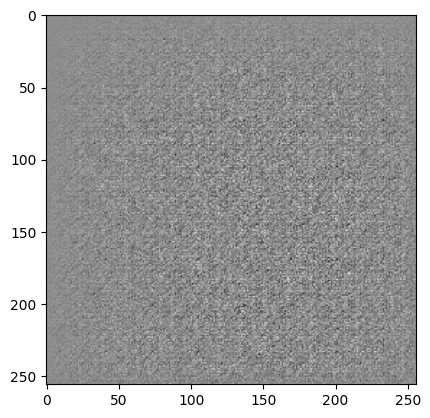

In [33]:
noise = tf.random.normal([1, experiment['LATENT_DIM']])
generated_image = generator_model(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### Discriminator

The discriminator acts as a regular `binary classifier`. Half of the time it receives images from the training set and the other half from the generator. The discriminator notices a difference between the real and fake images, it sends a signal to the generator. This signal is the gradient that flows from the discriminator to the generator. By receiving it, the generator is able to adjust its parameters to get closer to the true data distribution. We want the discriminator to be able to distinguish between real and fake images. `Every` time we run a mini-`batch` through the `discriminator`, we get `logits`. These are the `unscaled values` from the model. However, we can divide the mini-batches that the discriminator receives in `two types`. The First, composed only with `real images` that come from the training set and the second, with only `fake images` a.k.a. the ones created by the generator.

In [34]:
def get_discriminator_model(input, lrelu_alpha=0.2):
    """
    Disciriminator network
    * input_shape: input images (real images and generated images)
    * lrelu_alpha: slope of lrelu activation function
    return: A tuple of (sigmoid probabilities, logits)
    """

    # TensorShape([1, 512, 512, 3]) to TensorShape([512, 512, 3])
    input = Input(shape=(input.shape[1:]), name='Discriminator_Input')
    x = layers.Conv2D(64, kernel_size=5, strides=2, padding="same", activation=None,
                  kernel_initializer=random_kernel_initializer)(input)
    x = layers.LeakyReLU(lrelu_alpha)(x)

    x = layers.Conv2D(128, kernel_size=5, strides=2, padding="same", activation=None,
                  kernel_initializer=random_kernel_initializer)(x)
    x = layers.BatchNormalization(epsilon=1e-5, momentum=0.9)(x)
    x = layers.LeakyReLU(lrelu_alpha)(x)

    x = layers.Conv2D(256, kernel_size=5, strides=2, padding="same", activation=None,
                  kernel_initializer=random_kernel_initializer)(x)
    x = layers.BatchNormalization(epsilon=1e-5, momentum=0.9)(x)
    x = layers.LeakyReLU(lrelu_alpha)(x)

    # Flatten it
    #x = layers.Reshape((64, 64, 256), name='Reshape_Layer_1')(x)
    x = layers.Reshape((32, 32, 256), name='Reshape_Layer_1')(x)
    #assert model.output_shape == (None, 64, 64, 256)  # Note: None is the batch size

    x = layers.Flatten()(x)   # 64*64*256

    logits = layers.Dense(1, kernel_initializer=random_kernel_initializer, activation=None)(x)  # from logist: TRUE
    outputs = tf.keras.activations.sigmoid(logits)

    model = Model(input, logits, name='Discriminator_Model')  # Return logits
    model.summary()
    tf.keras.utils.plot_model(model, "Discriminator_model.png")

    # Return output
    # out = model(x)
    # return outputs, logits

    # Return model
    return model

In [35]:
discriminator_model = get_discriminator_model(generated_image)
decision = discriminator_model(generated_image)

Model: "Discriminator_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Discriminator_Input (Input  [(None, 256, 256, 3)]     0         
 Layer)                                                          
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 64)      4864      
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 128, 128, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       204928    
                                                                 
 batch_normalization (Batch  (None, 64, 64, 128)       512       
 Normalization)                                                  
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 64, 64, 128

In [36]:
print (decision)

tf.Tensor([[-0.00318669]], shape=(1, 1), dtype=float32)


The discriminator predicts 0 (fake image) for the generated image from input noise by the generator.

### Training [DCGAN model](https://arxiv.org/abs/1511.06434)

Because both networks train at the same time, GANs also need `two optimizers`. Each one for `minimizing` the `discriminator and generator’s loss` functions respectively. We want the discriminator to output probabilities close to `1` for `real` images and near `0` for `fake` images. To do that, the discriminator needs two losses. Therefor, the total loss for the discriminator is the `sum of these two partial losses`. One for maximizing the probabilities for the real images and another for minimizing the probability of fake images.


In the beginning discriminator receives `two` very `distinct` types of `batches`. One, composed of `true images` from the training set and another containing very `noisy signals`. As training progresses, the generator starts to output images that look closer to the images from the training set. At the same time, the discriminator starts to get real good at classifying samples as real or fake. As a consequence, the two types of mini-batches begin looking similar, in structure, to one another.

In this paper, `vanilla cross-entropy` with `Adam` was used as optimizer for the losses.

### Define Loss and Optimizer

In [37]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [44]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=experiment['LEARNING_RATE'], beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=experiment['LEARNING_RATE'], beta_1=0.5)

### Discriminator loss

This method quantifies how well the discriminator is able to `distinguish real images` from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [39]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss

The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, compare the discriminators decisions on the generated images to an array of 1s.

In [40]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

### Save Checkpoint

In [41]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator_model,
                                 discriminator=discriminator_model)

### Training Loop

The training loop begins with `generator receiving` a `random seed` as input. That seed is used to produce an image. The `discriminator` is then used to `classify` `real images` (drawn from the training set) and fakes images (produced by the generator). The `loss` is `calculated` for each of these models, and the gradients are used to update the generator and discriminator.

In [42]:
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, experiment['LATENT_DIM']])

In [45]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([experiment['BATCH_SIZE'], experiment['LATENT_DIM']])  # TensorShape[64, 250]

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator_model(noise, training=True)

      real_output = discriminator_model(images, training=True)
      fake_output = discriminator_model(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)  # Returns the sum of real_loss and fake_loss

    gradients_of_generator = gen_tape.gradient(gen_loss, generator_model.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator_model.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator_model.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator_model.trainable_variables))

    return [gen_loss, disc_loss]

In [46]:
def generate_and_save_images(model, epoch, test_input, figsize=(4,4)):
  # `training` is set to False.
  predictions = model(test_input, training=False)  # Inference mode

  print("test_input.shape: ", test_input.shape)
  print("predictions.shape: ", predictions.shape)

  fig = plt.figure(figsize=figsize)

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      # plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')  # denormalize
      plt.imshow(predictions[i, :, :, 0] * 255)  # denormalize - TODO: Use normalization as above, this type of normalization causes value range warnings in matplotlib
      plt.axis('off')   # No axis, show only image

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [47]:
import time
from IPython import display

def train(dataset, epochs):
  loss_hist = []  # Keep loss history
  for epoch in range(epochs):
    start_time = time.time()

    for image_batch in dataset:
        loss = train_step(image_batch)

    loss_hist.append(loss)   # Add loss value to the loss history after each epoch
    print(f"{epoch + 1}.epoch gen loss: {tf.reduce_mean(loss[0]).numpy()}, disc loss: {tf.reduce_mean(loss[1]).numpy()}")

    # Save the model every experiment['SAVE_WEIGHTS_PER_EPOCH'] epochs
    if (epoch + 1) % experiment['SAVE_WEIGHTS_PER_EPOCH'] == 0:
      # Produce images for the GIF as you go
      display.clear_output(wait=True)
      generate_and_save_images(generator_model, epoch + 1, seed)
      checkpoint.save(file_prefix = checkpoint_prefix)

      print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start_time))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator_model, epochs, seed)

### Train the Model

Call the `train()` method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real.

test_input.shape:  (16, 500)
predictions.shape:  (16, 256, 256, 3)


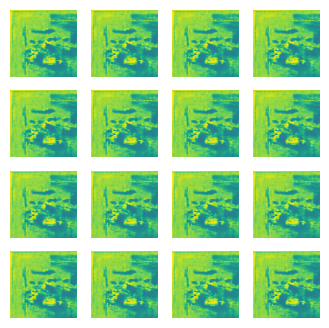

In [49]:
if experiment['TYPE'] == 'train':
    gan_model_hist = train(train_dataset, 100)
    #gan_model_hist = train(train_dataset, experiment['EPOCHS'])

In [47]:
#import shutil
#
#if experiment['TYPE'] == 'train':
#  shutil.copy('/content/tf_vae/BD67_dataset/training_weights/decoder_model_999.h5', '/content/drive/MyDrive/MASTER/Master_Thesis/Dataset/Chekpoints/cvae/experiment_3')
#  shutil.copy('/content/tf_vae/BD67_dataset/training_weights/encoder_model_999.h5', '/content/drive/MyDrive/MASTER/Master_Thesis/Dataset/Chekpoints/cvae/experiment_3')

In [ ]:
#plt.plot(gan_model_hist)

test_input.shape:  (16, 500)
predictions.shape:  (16, 256, 256, 3)


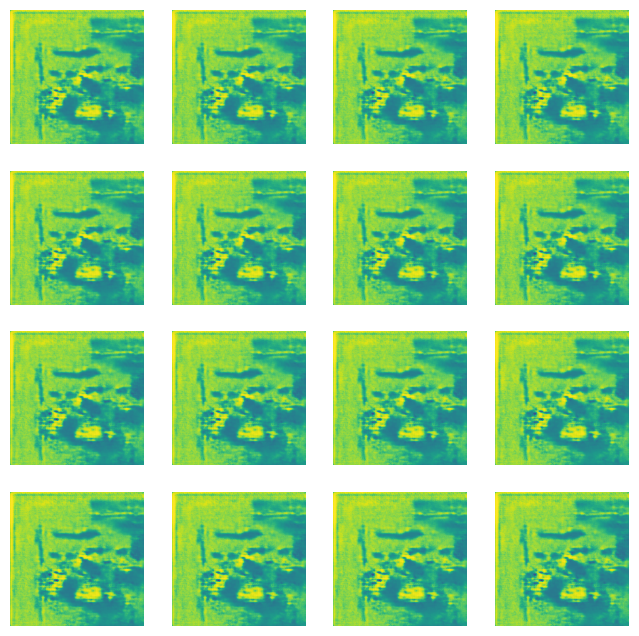

In [51]:
generate_and_save_images(generator_model, 0, seed, figsize=(8,8))

### Reference

https://sthalles.github.io/intro-to-gans/

https://www.tensorflow.org/tutorials/generative/dcgan

[Deep Convolutional Generative Adversarial Network (DCGAN)](https://arxiv.org/abs/1511.06434)

https://github.com/sthalles/blog-resources/blob/master/dcgan/DCGAN.ipynb

Dataset: http://ufldl.stanford.edu/housenumbers/

Citation:

@article{
  silva2017GANs,
  title={A Short Introduction to Generative Adversarial Networks},
  author={Silva, Thalles Santos},
  journal={https://sthalles.github.io},
  year={2017},
  url={https://sthalles.github.io/intro-to-gans/}
}